In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import mysql.connector

In [2]:
connection = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "admin@123",
                            database = "ecommerce")

cur = connection.cursor()


# <center>Questions<center>

### 1. List top 5 cities with highest number of customers.

In [3]:
query = '''select distinct(customer_city),count(customer_id) as No_of_customers
from customers
group by 1
order by 2 desc
limit 5;'''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data,columns=['Customer_City','No_of_Customers'])
df.head()

,Customer_City,No_of_Customers
0,sao paulo,18357
1,rio de janeiro,8112
2,belo horizonte,3288
3,brasilia,2495
4,curitiba,1780


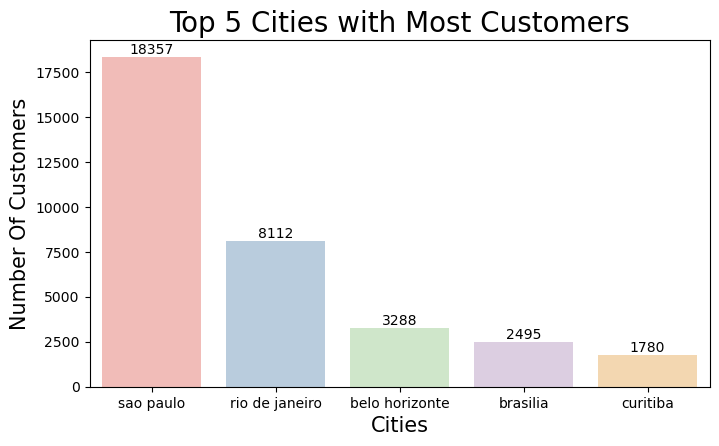

In [4]:
plt.figure(figsize=(8,4.5))
ax=sns.barplot(df,x='Customer_City',y='No_of_Customers',palette='Pastel1')
for bar in ax.containers:
    ax.bar_label(bar)
    
plt.title('Top 5 Cities with Most Customers',size=20)  
plt.xlabel('Cities',fontsize=15)
plt.ylabel('Number Of Customers',fontsize=15)
plt.show()    

### 2.Count the number of orders placed in 2017.

In [5]:
query = '''select count(order_id) as no_of_orders
from orders
where year(order_purchase_timestamp) = '2017';'''

cur.execute(query)

data=cur.fetchall()

print('No_of_orders:',data[0][0])

No_of_orders: 45101


### 3. Find the total sales per category.

In [6]:
query="""select pd.product_category,round(sum(payment_value),0) as sales
from order_items odi
join products pd
on odi.product_id = pd.product_id
join payments py
on odi.order_id = py.order_id
group by 1;
"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['Product_Category','Sales'])
df.head()

,Product_Category,Sales
0,perfumery,506739.0
1,Furniture Decoration,1430176.0
2,telephony,486882.0
3,bed table bath,1712554.0
4,automotive,852294.0


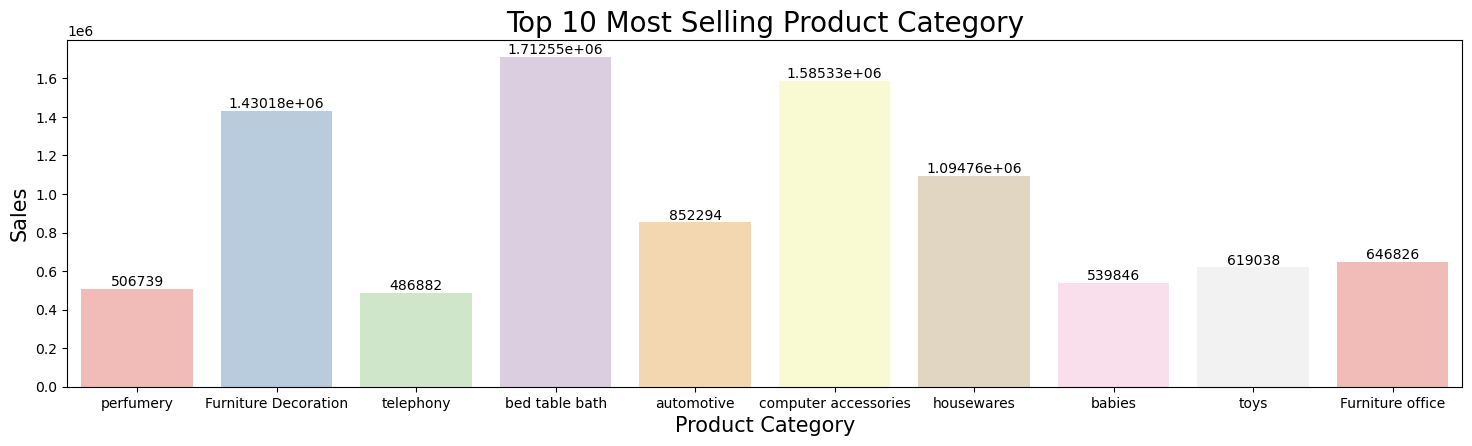

In [7]:
plt.figure(figsize=(18,4.5))
ax=sns.barplot(df.head(10),x='Product_Category',y='Sales',palette='Pastel1')
for bar in ax.containers:
    ax.bar_label(bar)
plt.title('Top 10 Most Selling Product Category',size=20)  
plt.xlabel('Product Category',fontsize=15)
plt.ylabel('Sales',fontsize=15)
plt.show()     

### 4. Calculate the percentage of orders that were paid in installments.

In [8]:
query="""select ((sum(case when payment_installments >= 1 then 1
else 0 end))/count(*))*100 as percentage
from payments ;"""

cur.execute(query)

data=cur.fetchall()

print('Percentage of orders that were paid in installments:',data[0][0],'%')

Percentage of orders that were paid in installments: 99.9981 %


### 5. Count the number of customers from each state.  

In [9]:
query="""select customer_state,count(customer_id) as no_of_customers
from customers
group by 1;"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['Customer_State','No_of_Customers'])
df.head()

,Customer_State,No_of_Customers
0,SP,49191
1,SC,4262
2,MG,13731
3,PR,5931
4,RJ,15192


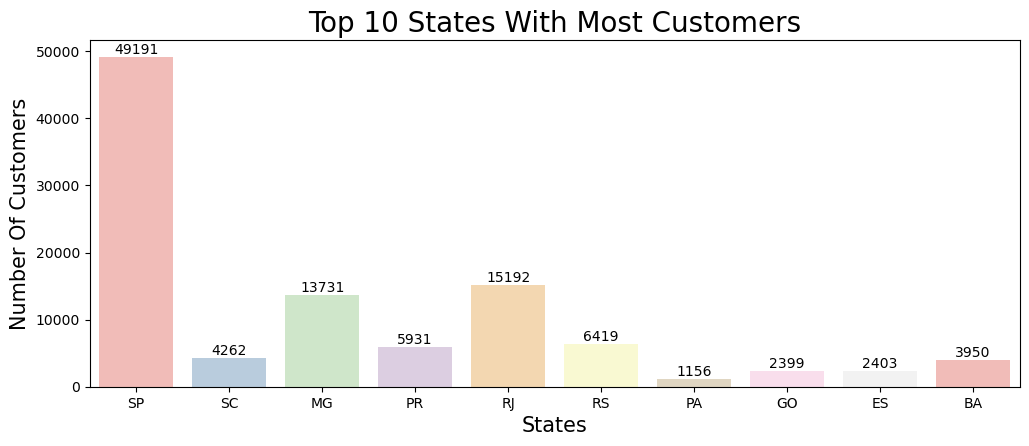

In [10]:
plt.figure(figsize=(12,4.5))
ax=sns.barplot(df.head(10),x='Customer_State',y='No_of_Customers',palette='Pastel1')
for bar in ax.containers:
    ax.bar_label(bar)
    
plt.title('Top 10 States With Most Customers',size=20)
plt.xlabel('States',size=15)
plt.ylabel('Number Of Customers',size=15)
plt.show()

### 6. Calculate the number of orders per month in 2018.

In [11]:
query="""select monthname(order_purchase_timestamp) as months,count(order_id) as no_of_orders 
from orders 
where year(order_purchase_timestamp) = '2018'
group by 1;"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['Months','No_of_Orders'])
df.head()

,Months,No_of_Orders
0,July,6292
1,August,6512
2,February,6728
3,June,6167
4,March,7211


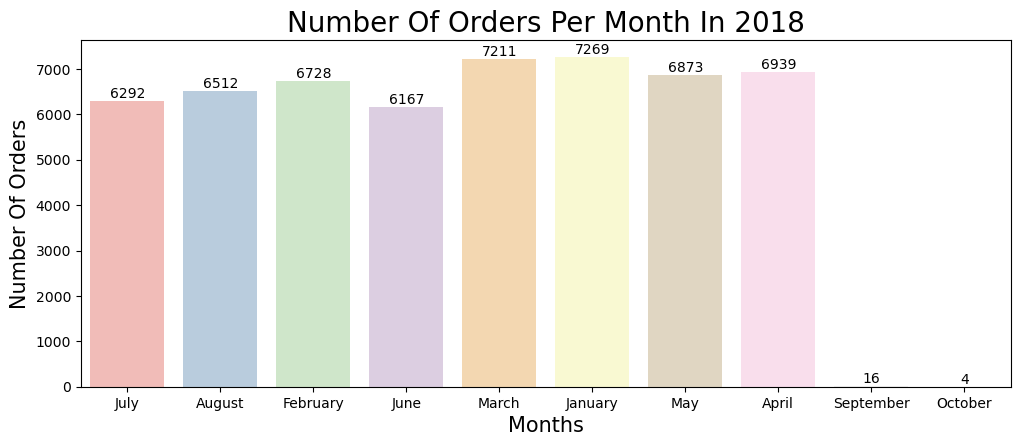

In [12]:
plt.figure(figsize=(12,4.5))
ax=sns.barplot(df,x='Months',y='No_of_Orders',palette='Pastel1')
for bar in ax.containers:
    ax.bar_label(bar)
    
plt.title('Number Of Orders Per Month In 2018',size=20)
plt.xlabel('Months',size=15)
plt.ylabel('Number Of Orders',size=15)
plt.show()

### 7.Find the average number of products per order, grouped by customer city.

In [13]:
query="""with count_per_order as
(select ord.order_id,ord.customer_id,count(odi.order_item_id) as no_of_items
from orders ord 
join order_items odi
on ord.order_id = odi.order_id
group by 1,2)

select cus.customer_city,avg(count_per_order.no_of_items) as avg_no_of_orders
from customers cus
join count_per_order
on count_per_order.customer_id = cus.customer_id
group by 1
order by 2 desc;"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['Customer_City','Avg_no_of_orders'])
df.head()

,Customer_City,Avg_no_of_orders
0,padre carvalho,7.0000
1,celso ramos,6.5000
2,datas,6.0000
3,candido godoi,6.0000
4,matias olimpio,5.0000


### 8.Calculate the percentage of total revenue contributed by each product category.

In [14]:
query="""select pd.product_category,round((sum(pys.payment_value)/(select sum(payment_value) from payments))*100,1) as percentage_of_sales
from order_items odi
join payments pys
on odi.order_id = pys.order_id
join products pd
on odi.product_id = pd.product_id
group by 1
order by 2 desc;"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['Product_Category','Percentage_of_sales'])
df.head()

,Product_Category,Percentage_of_sales
0,bed table bath,10.7
1,HEALTH BEAUTY,10.4
2,computer accessories,9.9
3,Furniture Decoration,8.9
4,Watches present,8.9


###  9.Identify the correlation between product price and the number of times a product has been purchased.

In [22]:
query="""select pd.product_category,count(pd.product_id) as no_of_items,round(avg(odi.price),2) as avg_price
from order_items odi
join products pd
on odi.product_id = pd.product_id 
group by 1
order by 2 desc;"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['Product_Category','No_of_items','Avg_price'])
df.head()

,Product_Category,No_of_items,Avg_price
0,bed table bath,11115,93.30
1,HEALTH BEAUTY,9670,130.16
2,sport leisure,8641,114.34
3,Furniture Decoration,8334,87.56
4,computer accessories,7827,116.51


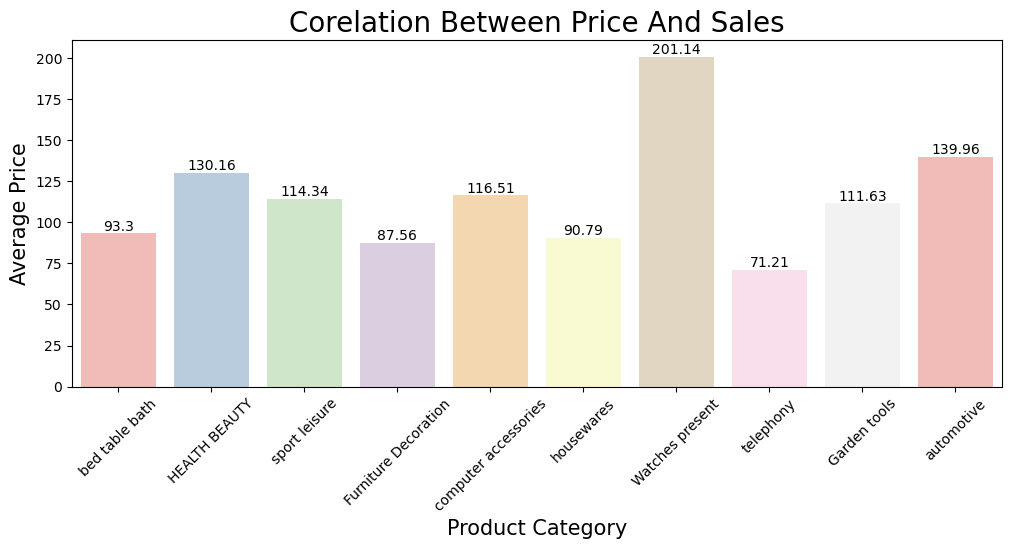

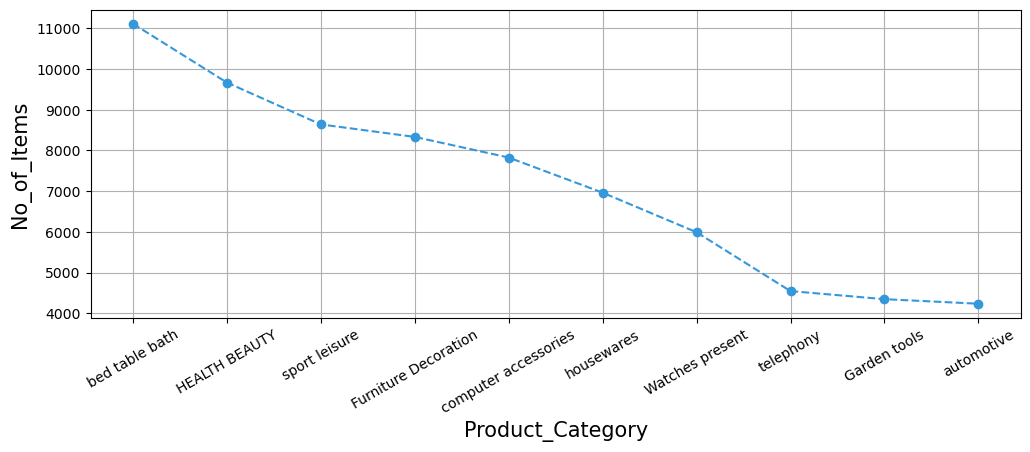

In [16]:
plt.figure(figsize=(12,4.5))
ax=sns.barplot(df.head(10),x='Product_Category',y='Avg_price',palette='Pastel1')
for bar in ax.containers:
    ax.bar_label(bar)
plt.xticks(rotation=45) 
plt.xlabel("Product Category",size=15)
plt.ylabel("Average Price",size=15)
plt.title("Corelation Between Price And Sales",size=20)
plt.show()

plt.figure(figsize=(12,4))
plt.grid()
lin=plt.plot(df.head(10)['Product_Category'],df.head(10)['No_of_items'],marker='o',linestyle='--',color='#3498db')
plt.xlabel('Product_Category',size=15)
plt.xticks(rotation=30)
plt.ylabel('No_of_Items',size=15)
plt.show()

### 10.Calculate the total revenue generated by each seller, and rank them by revenue.

In [17]:
query="""select *, dense_rank() over(order by revenue desc) as ranks
from 
(select sll.seller_id,round(sum(pys.payment_value),2) as revenue 
from order_items odi
join sellers sll
on odi.seller_id = sll.seller_id
join payments pys
on odi.order_id = pys.order_id
group by 1) t;"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['Seller_id','Revenue','Rank'])
df.head()

,Seller_id,Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5


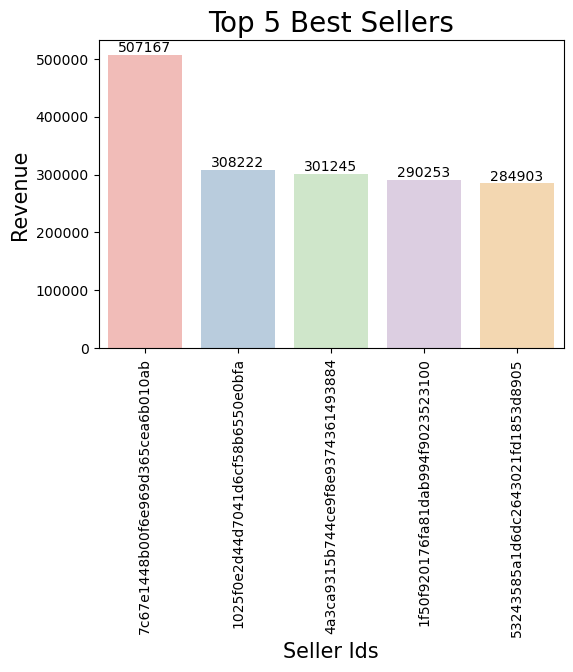

In [18]:
plt.figure(figsize=(6,4))
ax=sns.barplot(df.head(5),x='Seller_id',y='Revenue',palette='Pastel1')
for bar in ax.containers:
    ax.bar_label(bar)
plt.xticks(rotation=90) 
plt.xlabel("Seller Ids",size=15)
plt.ylabel("Revenue",size=15)
plt.title("Top 5 Best Sellers",size=20)
plt.show()

### 11.Calculate the moving average of order values for each customer over their order history.

In [19]:
query="""select customer_id,order_purchase_timestamp,payment,
avg(payment) 
over(partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row) as mov_avg
from
(select ord.customer_id,ord.order_purchase_timestamp,round(sum(pys.payment_value),2) as payment
from orders ord
join payments pys
on ord.order_id = pys.order_id
group by 1,2) t;"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['Customer_id','Order_purchase_timestamp','Payment','Mov_avg'])
df.head()

,Customer_id,Order_purchase_timestamp,Payment,Mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.42
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.35
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.01


### 12.Calculate the cumulative sales per month for each year.

In [50]:
query="""select *, sum(sales) over(order by year , months) cumulative_sales 
from 
(select year(order_purchase_timestamp) as year , monthname(order_purchase_timestamp) as months ,round(sum(pys.payment_value),2) as sales
from orders ord
join payments pys
on ord.order_id = pys.order_id 
group by 1,2
order by 1 desc) t;"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['Year', 'Months','Sales', 'Cumulative_Sales'])
df.head()

,Year,Months,Sales,Cumulative_Sales
0,2016,December,19.62,19.62
1,2016,October,59090.48,59110.10
2,2016,September,252.24,59362.34
3,2017,April,417788.03,477150.37
4,2017,August,674396.32,1151546.69


### 13.Identify the top 3 customers who spent the most money in each year and rank them according to their spending.

In [9]:
query="""select *
from 
(select year(ord.order_purchase_timestamp) year,ord.customer_id,round(sum(pys.payment_value),0) as max_spending,
dense_rank() over(partition by year(ord.order_purchase_timestamp)
order by sum(pys.payment_value) desc) d_rank
from orders ord
join payments pys
on ord.order_id = pys.order_id 
group by 1,2
order by 1 asc) t
where d_rank <=3;"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['Year', 'Customer_id','Max_Spending','Rank'])
df

,Year,Customer_id,Max_Spending,Rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1424.0,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1401.0,2
2,2016,4a06381959b6670756de02e07b83815f,1228.0,3
3,2017,1617b1357756262bfa56ab541c47bc16,13664.0,1
4,2017,c6e2731c5b391845f6800c97401a43a9,6929.0,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,6727.0,3
6,2018,ec5b2ba62e574342386871631fafd3fc,7275.0,1
7,2018,f48d464a0baaea338cb25f816991ab1f,6922.0,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,4809.0,3


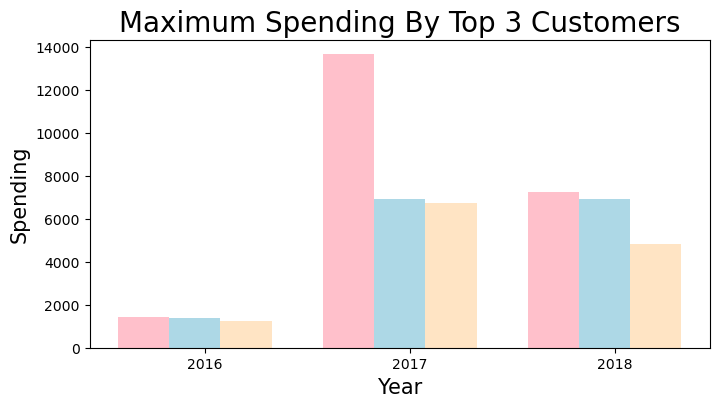

In [48]:
X=['2016','2017','2018']
a=[1424,13664,7275]
b=[1401,6929,6922]
c=[1228,6727,4809]

X=np.arange(3)
plt.figure(figsize=(8,4))
plt.bar(X+0.00,a,width=0.25,color='pink',label=L)
plt.bar(X+0.25,b,width=0.25,color='lightblue')
plt.bar(X+0.5,c,width=0.25,color='bisque')
plt.xticks(X+0.3,['2016','2017','2018'])
plt.title('Maximum Spending By Top 3 Customers',size='20')
plt.xlabel('Year',size='15')
plt.ylabel('Spending',size='15')
plt.show()